In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random 
from tqdm import tqdm
from data_utils.load_cora import *
from data_utils.load_pubmed import *

import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from sklearn.model_selection import ParameterGrid

/home/kshou/miniconda3/envs/gnn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed=0):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)  
    random.seed(seed)

set_seed(0)

In [13]:
# train one epoch
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, eval_split='test'):
    assert eval_split in ['train', 'val', 'test']
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits.argmax(dim=1)
        mask = data[f'{eval_split}_mask']       # 'train_mask', 'val_mask', 'test_mask'
        correct = (preds[mask] == data.y[mask]).sum()
        acc = int(correct) / int(mask.sum())
    return acc

def train_and_eval_once(model, data, optimizer, criterion, epochs=200, early_stop_ep=55, \
                        val_ep=1, mute=False):
    assert val_ep < early_stop_ep
    
    # eval before training on all three sets
    acc_train = evaluate(model, data, eval_split='train')
    acc_val = evaluate(model, data, eval_split='val')
    acc_test = evaluate(model, data, eval_split='test')
    if not mute:
        print(f'Accuracy before training: Train: {acc_train*100:.2f}%, Val: {acc_val*100:.2f}%, Test: {acc_test*100:.2f}%')

    # train
    epochs_no_improve = 0
    best_acc_val = 0.
    for i in tqdm(range(epochs)):
        epoch = i + 1
        loss = train(model, data, optimizer, criterion)

        # validation every val_ep epochs
        if epoch % val_ep == 0:
            acc_val = evaluate(model, data, eval_split='val')
            # if not mute:
            #     print(f'Epoch {epoch}, Loss: {loss:.4f}, Val Acc: {acc_val*100:.2f}%')
            
            if acc_val > best_acc_val:
                best_acc_val = acc_val
                epochs_no_improve = 0
            else:
                epochs_no_improve += val_ep

            if epochs_no_improve >= early_stop_ep:
                print(f'Early stopping at epoch {epoch}')
                break

    
    # eval after training on all three sets
    acc_train = evaluate(model, data, eval_split='train')
    acc_val = evaluate(model, data, eval_split='val')
    acc_test = evaluate(model, data, eval_split='test')
    if not mute:
        print(f'Accuracy after training: Train: {acc_train*100:.2f}%, Val: {acc_val*100:.2f}%, Test: {acc_test*100:.2f}%')
    
    acc_dict = {'train': acc_train, 'val': acc_val, 'test': acc_test}
    return acc_dict


In [4]:
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, num_classes, num_layers=2):
        super().__init__()
        assert num_layers >= 2
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(GCNConv(in_dim, hid_dim, cached=True))       # first layer
        
        for _ in range(num_layers - 2):
            self.conv_layers.append(GCNConv(hid_dim, hid_dim, cached=True))  # hidden layers
        
        self.conv_layers.append(GCNConv(hid_dim, num_classes, cached=True))   # last layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i, conv in enumerate(self.conv_layers[:-1]):
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv_layers[-1](x, edge_index)     # logit,    [N, num_classes]
        return x            

## GCN

### Cora

In [5]:
# load Cora
data_cora, _ = get_raw_text_cora(use_text=False)
data_cora.num_classes = data_cora.y.max().item() + 1      # 7

In [14]:
EPOCHS = 500
param_grid = {                      # 120 sets in total
    'lr': [1e-4, 1e-3, 0.01, 0.1],
    'hid_dim': [16, 32, 64, 128, 256, 512],
    'n_layers': [2, 3, 4, 5, 10]
}
param_comb = list(ParameterGrid(param_grid))
val_acc_best = 0.

data_cora = data_cora.cuda()
for c in param_comb:
    set_seed(0)
    lr = c['lr']
    hid_dim = c['hid_dim']
    n_layers = c['n_layers']

    model = GCN(data_cora.num_features, hid_dim, data_cora.num_classes, num_layers=n_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model = model.cuda()

    acc_dict = train_and_eval_once(model, data_cora, optimizer, criterion, epochs=EPOCHS, mute=True)
    if acc_dict['val'] > val_acc_best:
        val_acc_best = acc_dict['val']
        best_param = c
        train_acc_best = acc_dict['train']
        test_acc_best = acc_dict['test']

print(f'Best param: {best_param}, Best Val Acc: {val_acc_best*100:.2f}%')
print(f'With: Train Acc: {train_acc_best*100:.2f}%, Test Acc: {test_acc_best*100:.2f}%')

 20%|██        | 101/500 [00:00<00:02, 137.25it/s]


Early stopping at epoch 102


 42%|████▏     | 208/500 [00:02<00:03, 74.34it/s]


Early stopping at epoch 209


 42%|████▏     | 208/500 [00:00<00:01, 258.44it/s]


Early stopping at epoch 209


 45%|████▌     | 226/500 [00:01<00:01, 197.87it/s]


Early stopping at epoch 227


 49%|████▊     | 243/500 [00:01<00:01, 159.12it/s]


Early stopping at epoch 244


 67%|██████▋   | 335/500 [00:02<00:01, 135.83it/s]


Early stopping at epoch 336


 86%|████████▌ | 429/500 [00:05<00:00, 76.34it/s]


Early stopping at epoch 430


 15%|█▌        | 76/500 [00:00<00:01, 267.04it/s]


Early stopping at epoch 77


 16%|█▌        | 79/500 [00:00<00:02, 207.82it/s]


Early stopping at epoch 80


 19%|█▊        | 93/500 [00:00<00:02, 164.10it/s]


Early stopping at epoch 94


 21%|██        | 105/500 [00:00<00:02, 138.79it/s]


Early stopping at epoch 106


 77%|███████▋  | 386/500 [00:04<00:01, 77.22it/s]


Early stopping at epoch 387


 15%|█▍        | 74/500 [00:00<00:01, 272.00it/s]


Early stopping at epoch 75


 20%|██        | 102/500 [00:00<00:01, 211.20it/s]


Early stopping at epoch 103


 27%|██▋       | 134/500 [00:00<00:02, 161.22it/s]


Early stopping at epoch 135


 31%|███       | 153/500 [00:01<00:02, 148.99it/s]


Early stopping at epoch 154


 24%|██▍       | 119/500 [00:01<00:05, 73.89it/s]


Early stopping at epoch 120


 14%|█▍        | 69/500 [00:00<00:02, 199.93it/s]


Early stopping at epoch 70


 16%|█▌        | 81/500 [00:01<00:05, 73.75it/s]


Early stopping at epoch 82


 38%|███▊      | 189/500 [00:00<00:01, 254.51it/s]


Early stopping at epoch 190


 27%|██▋       | 136/500 [00:00<00:01, 198.03it/s]


Early stopping at epoch 137


 33%|███▎      | 163/500 [00:01<00:02, 160.14it/s]


Early stopping at epoch 164


 39%|███▊      | 193/500 [00:01<00:02, 132.33it/s]


Early stopping at epoch 194


 11%|█▏        | 57/500 [00:00<00:06, 73.62it/s]


Early stopping at epoch 58


 14%|█▍        | 72/500 [00:00<00:01, 258.57it/s]


Early stopping at epoch 73


 14%|█▍        | 71/500 [00:00<00:02, 197.87it/s]


Early stopping at epoch 72


 15%|█▌        | 76/500 [00:00<00:02, 163.17it/s]


Early stopping at epoch 77


 17%|█▋        | 85/500 [00:00<00:03, 136.34it/s]


Early stopping at epoch 86


 80%|████████  | 402/500 [00:05<00:01, 68.60it/s]


Early stopping at epoch 403


 16%|█▌        | 81/500 [00:00<00:01, 266.47it/s]


Early stopping at epoch 82


 21%|██        | 106/500 [00:00<00:01, 211.47it/s]


Early stopping at epoch 107


 63%|██████▎   | 316/500 [00:01<00:01, 158.31it/s]


Early stopping at epoch 317


 12%|█▏        | 62/500 [00:00<00:05, 73.66it/s]


Early stopping at epoch 63


 86%|████████▌ | 429/500 [00:01<00:00, 255.24it/s]


Early stopping at epoch 430


 17%|█▋        | 87/500 [00:00<00:02, 159.00it/s]


Early stopping at epoch 88


 12%|█▏        | 61/500 [00:00<00:03, 136.41it/s]


Early stopping at epoch 62


 11%|█▏        | 57/500 [00:00<00:06, 71.04it/s]


Early stopping at epoch 58


 26%|██▋       | 132/500 [00:00<00:01, 252.45it/s]


Early stopping at epoch 133


 25%|██▍       | 124/500 [00:00<00:01, 194.75it/s]


Early stopping at epoch 125


 21%|██        | 106/500 [00:00<00:02, 158.80it/s]


Early stopping at epoch 107


 26%|██▌       | 130/500 [00:00<00:02, 134.35it/s]


Early stopping at epoch 131


 62%|██████▏   | 309/500 [00:04<00:02, 66.74it/s]


Early stopping at epoch 310


 14%|█▍        | 69/500 [00:00<00:01, 255.15it/s]


Early stopping at epoch 70


 13%|█▎        | 66/500 [00:00<00:02, 198.27it/s]


Early stopping at epoch 67


 14%|█▍        | 69/500 [00:00<00:02, 159.87it/s]


Early stopping at epoch 70


 19%|█▉        | 94/500 [00:00<00:03, 132.91it/s]


Early stopping at epoch 95


 44%|████▎     | 218/500 [00:03<00:04, 67.36it/s]


Early stopping at epoch 219


 15%|█▍        | 73/500 [00:00<00:01, 253.14it/s]


Early stopping at epoch 74


 28%|██▊       | 139/500 [00:00<00:01, 193.83it/s]


Early stopping at epoch 140


 36%|███▌      | 180/500 [00:01<00:02, 152.91it/s]


Early stopping at epoch 181


 46%|████▌     | 230/500 [00:01<00:02, 127.84it/s]


Early stopping at epoch 231


 17%|█▋        | 87/500 [00:01<00:06, 68.66it/s]


Early stopping at epoch 88


 13%|█▎        | 66/500 [00:00<00:02, 199.24it/s]


Early stopping at epoch 67


 14%|█▍        | 69/500 [00:00<00:02, 162.25it/s]


Early stopping at epoch 70


 13%|█▎        | 63/500 [00:00<00:03, 134.89it/s]


Early stopping at epoch 64


 11%|█         | 56/500 [00:00<00:06, 70.91it/s]


Early stopping at epoch 57


 23%|██▎       | 113/500 [00:00<00:01, 246.23it/s]


Early stopping at epoch 114


 20%|█▉        | 98/500 [00:00<00:02, 192.52it/s]


Early stopping at epoch 99


 19%|█▉        | 94/500 [00:00<00:02, 155.13it/s]


Early stopping at epoch 95


 20%|██        | 100/500 [00:00<00:03, 129.25it/s]


Early stopping at epoch 101


 52%|█████▏    | 262/500 [00:03<00:03, 67.34it/s]


Early stopping at epoch 263


 13%|█▎        | 65/500 [00:00<00:01, 257.18it/s]


Early stopping at epoch 66


 12%|█▏        | 62/500 [00:00<00:02, 195.83it/s]


Early stopping at epoch 63


 14%|█▎        | 68/500 [00:00<00:02, 157.05it/s]


Early stopping at epoch 69


 16%|█▋        | 82/500 [00:00<00:03, 131.87it/s]


Early stopping at epoch 83


 47%|████▋     | 236/500 [00:03<00:03, 68.06it/s]


Early stopping at epoch 237


 13%|█▎        | 65/500 [00:00<00:01, 245.07it/s]


Early stopping at epoch 66


 33%|███▎      | 166/500 [00:00<00:01, 195.87it/s]


Early stopping at epoch 167


 41%|████      | 206/500 [00:01<00:02, 140.34it/s]


Early stopping at epoch 207


 11%|█         | 55/500 [00:00<00:03, 132.75it/s]


Early stopping at epoch 56


 12%|█▏        | 60/500 [00:00<00:06, 71.34it/s]


Early stopping at epoch 61


 76%|███████▌  | 378/500 [00:01<00:00, 251.23it/s]


Early stopping at epoch 379


 12%|█▏        | 60/500 [00:00<00:02, 199.09it/s]


Early stopping at epoch 61


 11%|█         | 56/500 [00:00<00:02, 164.95it/s]


Early stopping at epoch 57


 12%|█▏        | 58/500 [00:00<00:03, 134.48it/s]


Early stopping at epoch 59


 12%|█▏        | 59/500 [00:00<00:06, 69.84it/s]


Early stopping at epoch 60


 19%|█▉        | 96/500 [00:00<00:01, 283.74it/s]


Early stopping at epoch 97


 18%|█▊        | 91/500 [00:00<00:02, 202.13it/s]


Early stopping at epoch 92


 17%|█▋        | 86/500 [00:00<00:02, 158.36it/s]


Early stopping at epoch 87


 17%|█▋        | 85/500 [00:00<00:03, 132.00it/s]


Early stopping at epoch 86


 52%|█████▏    | 258/500 [00:03<00:03, 67.06it/s]


Early stopping at epoch 259


 12%|█▏        | 60/500 [00:00<00:01, 251.06it/s]


Early stopping at epoch 61


 12%|█▏        | 61/500 [00:00<00:02, 199.52it/s]


Early stopping at epoch 62


 14%|█▍        | 69/500 [00:00<00:02, 161.75it/s]


Early stopping at epoch 70


 16%|█▌        | 81/500 [00:00<00:03, 134.64it/s]


Early stopping at epoch 82


 61%|██████▏   | 307/500 [00:04<00:02, 67.58it/s]


Early stopping at epoch 308


 13%|█▎        | 65/500 [00:00<00:01, 259.81it/s]


Early stopping at epoch 66


 49%|████▊     | 243/500 [00:01<00:01, 190.60it/s]


Early stopping at epoch 244


 12%|█▏        | 61/500 [00:00<00:02, 158.91it/s]


Early stopping at epoch 62


 11%|█         | 55/500 [00:00<00:03, 135.70it/s]


Early stopping at epoch 56


 15%|█▌        | 76/500 [00:01<00:06, 69.10it/s]


Early stopping at epoch 77


 55%|█████▌    | 276/500 [00:01<00:00, 242.72it/s]


Early stopping at epoch 277


 43%|████▎     | 213/500 [00:01<00:01, 186.10it/s]


Early stopping at epoch 214


 35%|███▌      | 175/500 [00:01<00:02, 149.90it/s]


Early stopping at epoch 176


 31%|███       | 156/500 [00:01<00:02, 126.49it/s]


Early stopping at epoch 157


 11%|█         | 56/500 [00:00<00:06, 67.02it/s]


Early stopping at epoch 57


 17%|█▋        | 83/500 [00:00<00:01, 259.31it/s]


Early stopping at epoch 84


 15%|█▍        | 74/500 [00:00<00:02, 198.40it/s]


Early stopping at epoch 75


 16%|█▌        | 79/500 [00:00<00:02, 155.99it/s]


Early stopping at epoch 80


 16%|█▋        | 82/500 [00:00<00:03, 131.49it/s]


Early stopping at epoch 83


 50%|████▉     | 249/500 [00:03<00:03, 64.41it/s]


Early stopping at epoch 250


 14%|█▍        | 69/500 [00:00<00:01, 253.49it/s]


Early stopping at epoch 70


 14%|█▍        | 70/500 [00:00<00:02, 197.39it/s]


Early stopping at epoch 71


 16%|█▌        | 78/500 [00:00<00:02, 158.50it/s]


Early stopping at epoch 79


 28%|██▊       | 138/500 [00:01<00:02, 129.53it/s]


Early stopping at epoch 139


 69%|██████▊   | 343/500 [00:05<00:02, 64.83it/s]


Early stopping at epoch 344


 13%|█▎        | 65/500 [00:00<00:01, 259.06it/s]


Early stopping at epoch 66


 45%|████▌     | 226/500 [00:01<00:01, 190.76it/s]


Early stopping at epoch 227


 24%|██▍       | 122/500 [00:00<00:02, 154.61it/s]


Early stopping at epoch 123


 32%|███▏      | 162/500 [00:01<00:02, 126.72it/s]


Early stopping at epoch 163


 13%|█▎        | 64/500 [00:00<00:06, 67.45it/s]

Early stopping at epoch 65
Best param: {'hid_dim': 128, 'lr': 0.0001, 'n_layers': 2}, Best Val Acc: 89.11%
With: Train Acc: 92.67%, Test Acc: 90.59%


Learning rate: 0.0001


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:01<00:00, 256.27it/s]


Learning rate: 0.001


 23%|██▎       | 113/500 [00:00<00:01, 257.85it/s]


Early stopping at epoch 114
Learning rate: 0.01


 13%|█▎        | 65/500 [00:00<00:01, 252.51it/s]


Early stopping at epoch 66
Learning rate: 0.1


 13%|█▎        | 65/500 [00:00<00:01, 252.00it/s]


Early stopping at epoch 66


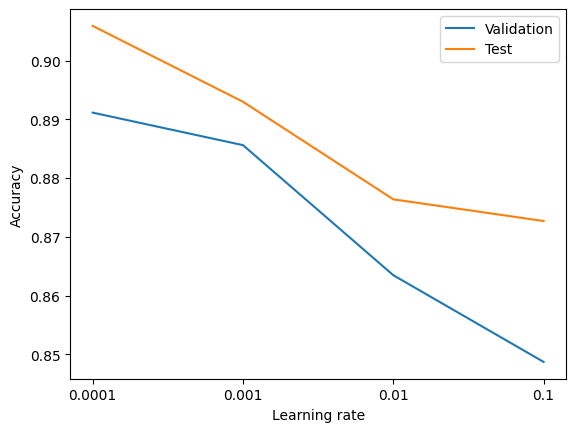

acc val: [0.8911439114391144, 0.8856088560885609, 0.8634686346863468, 0.8487084870848709]
acc test: [0.9059040590405905, 0.8929889298892989, 0.8763837638376384, 0.8726937269372693]


In [7]:
lr_search = [1e-4, 1e-3, 0.01, 0.1]
epochs = 500
hid_dim = 128
n_layers = 2

acc_val_list = []
acc_test_list = []
data_cora = data_cora.cuda()
for lr in lr_search:
    set_seed(0)
    model = GCN(data_cora.num_features, hid_dim, data_cora.num_classes, num_layers=n_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model = model.cuda()
    print(f'Learning rate: {lr}')
    acc_dict = train_and_eval_once(model, data_cora, optimizer, nn.CrossEntropyLoss(), epochs=epochs, mute=True)
    acc_val_list.append(acc_dict['val'])
    acc_test_list.append(acc_dict['test'])

# plot
plt.plot([str(lr) for lr in lr_search], acc_val_list, label='Validation')
plt.plot([str(lr) for lr in lr_search], acc_test_list, label='Test')
# plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"acc val: {acc_val_list}")
print(f"acc test: {acc_test_list}")

Hidden dimension: 16


100%|██████████| 500/500 [00:02<00:00, 231.42it/s]


Hidden dimension: 32


100%|██████████| 500/500 [00:01<00:00, 253.58it/s]


Hidden dimension: 64


 86%|████████▌ | 429/500 [00:01<00:00, 253.07it/s]


Early stopping at epoch 430
Hidden dimension: 128


100%|██████████| 500/500 [00:01<00:00, 252.44it/s]


Hidden dimension: 256


 76%|███████▌  | 378/500 [00:01<00:00, 254.10it/s]


Early stopping at epoch 379
Hidden dimension: 512


 55%|█████▌    | 276/500 [00:01<00:00, 249.15it/s]


Early stopping at epoch 277


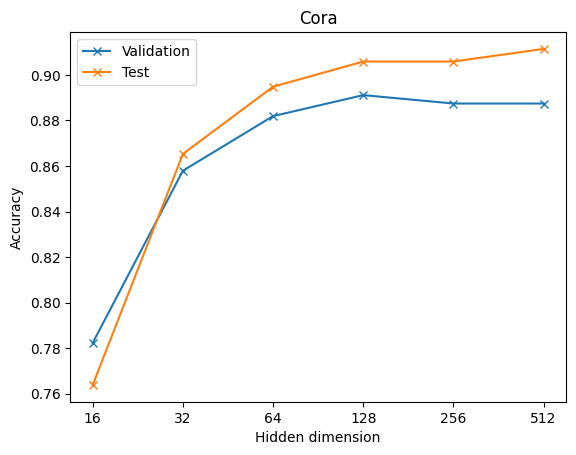

acc val: [0.7822878228782287, 0.8579335793357934, 0.8819188191881919, 0.8911439114391144, 0.8874538745387454, 0.8874538745387454]
acc test: [0.7638376383763837, 0.8653136531365314, 0.8948339483394834, 0.9059040590405905, 0.9059040590405905, 0.9114391143911439]


In [13]:
hid_dim_search = [16, 32, 64, 128, 256, 512]
epochs = 500
lr = 1e-4
n_layers = 2

acc_val_list = []
acc_test_list = []
data_cora = data_cora.cuda()
for hid_dim in hid_dim_search:
    set_seed(0)
    model = GCN(data_cora.num_features, hid_dim, data_cora.num_classes, num_layers=n_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model = model.cuda()
    print(f'Hidden dimension: {hid_dim}')
    acc_dict = train_and_eval_once(model, data_cora, optimizer, nn.CrossEntropyLoss(), epochs=epochs, mute=True)
    acc_val_list.append(acc_dict['val'])
    acc_test_list.append(acc_dict['test'])

# plot
plt.plot([str(d) for d in hid_dim_search], acc_val_list, marker='x', label='Validation')
plt.plot([str(d) for d in hid_dim_search], acc_test_list, marker='x', label='Test')
plt.xlabel('Hidden dimension')
plt.ylabel('Accuracy')
plt.title('Cora')
plt.legend()
plt.savefig('cora_gnn_hid_dim.pdf', bbox_inches='tight')
plt.show()


print(f"acc val: {acc_val_list}")
print(f"acc test: {acc_test_list}")

Number of layers: 2


100%|██████████| 500/500 [00:01<00:00, 256.16it/s]


Number of layers: 3


 13%|█▎        | 66/500 [00:00<00:02, 178.22it/s]


Early stopping at epoch 67
Number of layers: 4


 14%|█▍        | 69/500 [00:00<00:03, 140.90it/s]


Early stopping at epoch 70
Number of layers: 5


 13%|█▎        | 63/500 [00:00<00:03, 119.81it/s]


Early stopping at epoch 64
Number of layers: 10


 11%|█         | 56/500 [00:00<00:05, 79.64it/s]


Early stopping at epoch 57


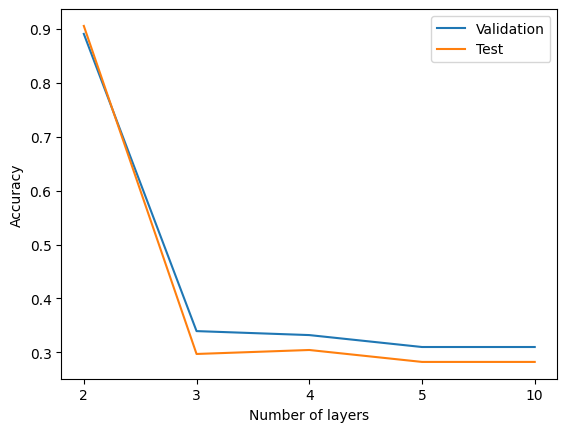

acc val: [0.8911439114391144, 0.33948339483394835, 0.33210332103321033, 0.30996309963099633, 0.30996309963099633]
acc test: [0.9059040590405905, 0.29704797047970477, 0.3044280442804428, 0.2822878228782288, 0.2822878228782288]


In [14]:
hid_dim = 128
epochs = 500
lr = 1e-4
n_layers_search = [2, 3, 4, 5, 10]

acc_val_list = []
acc_test_list = []
data_cora = data_cora.cuda()
for n_layers in n_layers_search:
    set_seed(0)
    model = GCN(data_cora.num_features, hid_dim, data_cora.num_classes, num_layers=n_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model = model.cuda()
    print(f'Number of layers: {n_layers}')
    acc_dict = train_and_eval_once(model, data_cora, optimizer, nn.CrossEntropyLoss(), epochs=epochs, mute=True)
    acc_val_list.append(acc_dict['val'])
    acc_test_list.append(acc_dict['test'])

# plot
plt.plot([str(d) for d in n_layers_search], acc_val_list, label='Validation')
plt.plot([str(d) for d in n_layers_search], acc_test_list, label='Test')
plt.xlabel('Number of layers')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"acc val: {acc_val_list}")
print(f"acc test: {acc_test_list}")

### Pubmed

In [5]:
# load Pubmed
data_pubmed, _ = get_raw_text_pubmed(use_text=False)
data_pubmed.num_classes = data_pubmed.y.max().item() + 1      # 3

In [6]:
EPOCHS = 500
param_grid = {                      # 120 sets in total
    'lr': [1e-4, 1e-3, 0.01, 0.1],
    'hid_dim': [16, 32, 64, 128, 256, 512],
    'n_layers': [2, 3, 4, 5, 10]
}
param_comb = list(ParameterGrid(param_grid))
val_acc_best = 0.

data_pubmed = data_pubmed.cuda()
for c in param_comb:
    set_seed(0)
    lr = c['lr']
    hid_dim = c['hid_dim']
    n_layers = c['n_layers']

    model = GCN(data_pubmed.num_features, hid_dim, data_pubmed.num_classes, num_layers=n_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model = model.cuda()

    acc_dict = train_and_eval_once(model, data_pubmed, optimizer, criterion, epochs=EPOCHS, mute=True)
    if acc_dict['val'] > val_acc_best:
        val_acc_best = acc_dict['val']
        best_param = c
        train_acc_best = acc_dict['train']
        test_acc_best = acc_dict['test']

print(f'Best param: {best_param}, Best Val Acc: {val_acc_best*100:.2f}%')
print(f'With: Train Acc: {train_acc_best*100:.2f}%, Test Acc: {test_acc_best*100:.2f}%')

 11%|█▏        | 57/500 [00:00<00:02, 173.97it/s]


Early stopping at epoch 58


 13%|█▎        | 64/500 [00:00<00:03, 143.35it/s]


Early stopping at epoch 65


 10%|█         | 50/500 [00:00<00:02, 154.00it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:06, 72.07it/s]


Early stopping at epoch 51


 10%|█         | 51/500 [00:00<00:03, 138.53it/s]


Early stopping at epoch 52


 50%|█████     | 252/500 [00:02<00:02, 106.78it/s]


Early stopping at epoch 253


 70%|██████▉   | 348/500 [00:05<00:02, 63.94it/s]


Early stopping at epoch 349


 78%|███████▊  | 389/500 [00:01<00:00, 214.65it/s]


Early stopping at epoch 390


 49%|████▉     | 247/500 [00:01<00:01, 172.11it/s]


Early stopping at epoch 248


 56%|█████▌    | 281/500 [00:01<00:01, 141.16it/s]


Early stopping at epoch 282


 56%|█████▌    | 278/500 [00:02<00:01, 112.31it/s]


Early stopping at epoch 279


 61%|██████▏   | 307/500 [00:04<00:03, 63.94it/s]


Early stopping at epoch 308


 38%|███▊      | 188/500 [00:00<00:01, 210.36it/s]


Early stopping at epoch 189


 32%|███▏      | 160/500 [00:00<00:01, 172.37it/s]


Early stopping at epoch 161


 40%|████      | 202/500 [00:01<00:02, 140.98it/s]


Early stopping at epoch 203


 64%|██████▍   | 319/500 [00:02<00:01, 117.92it/s]


Early stopping at epoch 320


 10%|█         | 51/500 [00:00<00:06, 67.48it/s]


Early stopping at epoch 52


 12%|█▏        | 61/500 [00:00<00:02, 172.33it/s]


Early stopping at epoch 62


 10%|█         | 52/500 [00:00<00:03, 142.65it/s]


Early stopping at epoch 53


 10%|█         | 50/500 [00:00<00:03, 122.07it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:06, 68.32it/s]


Early stopping at epoch 51


 44%|████▍     | 219/500 [00:01<00:02, 113.26it/s]


Early stopping at epoch 220


 44%|████▎     | 218/500 [00:03<00:04, 67.31it/s]


Early stopping at epoch 219


 43%|████▎     | 213/500 [00:01<00:01, 169.07it/s]


Early stopping at epoch 214


 44%|████▎     | 218/500 [00:01<00:02, 138.35it/s]


Early stopping at epoch 219


 44%|████▍     | 219/500 [00:01<00:02, 111.57it/s]


Early stopping at epoch 220


 39%|███▉      | 194/500 [00:03<00:04, 64.26it/s]


Early stopping at epoch 195


 22%|██▏       | 111/500 [00:00<00:01, 209.90it/s]


Early stopping at epoch 112


 33%|███▎      | 167/500 [00:00<00:01, 169.40it/s]


Early stopping at epoch 168


 59%|█████▉    | 294/500 [00:02<00:01, 136.34it/s]


Early stopping at epoch 295


 45%|████▌     | 226/500 [00:01<00:02, 117.81it/s]


Early stopping at epoch 227


 12%|█▏        | 58/500 [00:00<00:06, 65.78it/s]


Early stopping at epoch 59


 57%|█████▋    | 283/500 [00:01<00:01, 212.16it/s]


Early stopping at epoch 284


 13%|█▎        | 64/500 [00:00<00:02, 155.80it/s]


Early stopping at epoch 65


 11%|█         | 53/500 [00:00<00:03, 141.68it/s]


Early stopping at epoch 54


 10%|█         | 50/500 [00:00<00:06, 67.09it/s]


Early stopping at epoch 51


 74%|███████▍  | 369/500 [00:02<00:00, 138.49it/s]


Early stopping at epoch 370


 73%|███████▎  | 367/500 [00:03<00:01, 114.35it/s]


Early stopping at epoch 368


 73%|███████▎  | 365/500 [00:05<00:02, 63.66it/s]


Early stopping at epoch 366


 89%|████████▉ | 444/500 [00:02<00:00, 211.64it/s]


Early stopping at epoch 445


 34%|███▍      | 169/500 [00:01<00:01, 168.49it/s]


Early stopping at epoch 170


 44%|████▍     | 220/500 [00:01<00:02, 136.88it/s]


Early stopping at epoch 221


 40%|████      | 201/500 [00:01<00:02, 115.52it/s]


Early stopping at epoch 202


 57%|█████▋    | 284/500 [00:04<00:03, 70.35it/s]


Early stopping at epoch 285


 31%|███       | 155/500 [00:00<00:01, 217.81it/s]


Early stopping at epoch 156


 23%|██▎       | 116/500 [00:00<00:02, 170.26it/s]


Early stopping at epoch 117


 37%|███▋      | 184/500 [00:01<00:02, 138.24it/s]


Early stopping at epoch 185


 31%|███▏      | 157/500 [00:01<00:02, 119.21it/s]


Early stopping at epoch 158


 17%|█▋        | 83/500 [00:01<00:06, 65.35it/s]


Early stopping at epoch 84


 12%|█▏        | 58/500 [00:00<00:02, 187.41it/s]


Early stopping at epoch 59


 14%|█▎        | 68/500 [00:00<00:03, 135.70it/s]


Early stopping at epoch 69


 10%|█         | 50/500 [00:01<00:11, 40.78it/s]


Early stopping at epoch 51


 85%|████████▍ | 424/500 [00:03<00:00, 138.98it/s]


Early stopping at epoch 425


 60%|██████    | 301/500 [00:02<00:01, 101.38it/s]


Early stopping at epoch 302


 65%|██████▍   | 324/500 [00:04<00:02, 80.02it/s]


Early stopping at epoch 325


 28%|██▊       | 141/500 [00:03<00:08, 41.19it/s]


Early stopping at epoch 142


 54%|█████▍    | 270/500 [00:01<00:01, 194.54it/s]


Early stopping at epoch 271


 29%|██▉       | 146/500 [00:01<00:02, 138.58it/s]


Early stopping at epoch 147


 36%|███▌      | 178/500 [00:01<00:03, 101.03it/s]


Early stopping at epoch 179


 72%|███████▏  | 359/500 [00:04<00:01, 80.03it/s]


Early stopping at epoch 360


 41%|████      | 204/500 [00:04<00:07, 41.36it/s]


Early stopping at epoch 205


 28%|██▊       | 139/500 [00:00<00:01, 192.24it/s]


Early stopping at epoch 140


 36%|███▌      | 178/500 [00:01<00:02, 138.76it/s]


Early stopping at epoch 179


 51%|█████     | 253/500 [00:02<00:02, 101.78it/s]


Early stopping at epoch 254


 57%|█████▋    | 286/500 [00:03<00:02, 80.66it/s]


Early stopping at epoch 287


 15%|█▌        | 75/500 [00:01<00:10, 40.88it/s]


Early stopping at epoch 76


 47%|████▋     | 233/500 [00:11<00:12, 20.57it/s]


Early stopping at epoch 234


 97%|█████████▋| 487/500 [00:03<00:00, 135.97it/s]


Early stopping at epoch 488


 46%|████▌     | 231/500 [00:03<00:03, 76.82it/s]


Early stopping at epoch 232


 46%|████▌     | 230/500 [00:04<00:04, 54.32it/s]


Early stopping at epoch 231


 60%|█████▉    | 298/500 [00:06<00:04, 43.81it/s]


Early stopping at epoch 299


 45%|████▍     | 223/500 [00:10<00:13, 20.56it/s]


Early stopping at epoch 224


 51%|█████     | 254/500 [00:01<00:01, 135.54it/s]


Early stopping at epoch 255


 30%|███       | 150/500 [00:01<00:04, 76.39it/s]


Early stopping at epoch 151


 39%|███▊      | 193/500 [00:03<00:05, 54.20it/s]


Early stopping at epoch 194


 59%|█████▊    | 293/500 [00:06<00:04, 43.80it/s]


Early stopping at epoch 294


 55%|█████▌    | 277/500 [00:13<00:10, 20.64it/s]


Early stopping at epoch 278


 35%|███▌      | 177/500 [00:01<00:02, 135.71it/s]


Early stopping at epoch 178


 36%|███▌      | 180/500 [00:02<00:04, 76.40it/s]


Early stopping at epoch 181


 42%|████▏     | 209/500 [00:03<00:05, 54.51it/s]


Early stopping at epoch 210


 15%|█▍        | 74/500 [00:01<00:09, 43.47it/s]


Early stopping at epoch 75


 13%|█▎        | 64/500 [00:03<00:21, 20.41it/s]


Early stopping at epoch 65


 23%|██▎       | 114/500 [00:01<00:05, 73.14it/s]


Early stopping at epoch 115


 97%|█████████▋| 485/500 [00:17<00:00, 27.54it/s]


Early stopping at epoch 486


 72%|███████▏  | 362/500 [00:17<00:06, 20.81it/s]


Early stopping at epoch 363


 41%|████      | 204/500 [00:21<00:31,  9.50it/s]


Early stopping at epoch 205


 74%|███████▎  | 368/500 [00:04<00:01, 73.81it/s]


Early stopping at epoch 369


 40%|████      | 202/500 [00:05<00:07, 40.06it/s]


Early stopping at epoch 203


 36%|███▌      | 178/500 [00:06<00:11, 27.41it/s]


Early stopping at epoch 179


 39%|███▉      | 195/500 [00:09<00:14, 20.77it/s]


Early stopping at epoch 196


 47%|████▋     | 235/500 [00:24<00:27,  9.53it/s]


Early stopping at epoch 236


 50%|█████     | 250/500 [00:03<00:03, 72.84it/s]


Early stopping at epoch 251


 33%|███▎      | 166/500 [00:04<00:08, 38.16it/s]


Early stopping at epoch 167


 41%|████▏     | 207/500 [00:07<00:11, 26.38it/s]


Early stopping at epoch 208


 31%|███       | 154/500 [00:07<00:16, 20.93it/s]


Early stopping at epoch 155


 15%|█▌        | 76/500 [00:07<00:44,  9.52it/s]


Early stopping at epoch 77


 29%|██▊       | 143/500 [00:01<00:04, 73.57it/s]


Early stopping at epoch 144


 37%|███▋      | 184/500 [00:04<00:07, 40.33it/s]


Early stopping at epoch 185


 32%|███▏      | 161/500 [00:05<00:12, 27.64it/s]


Early stopping at epoch 162


 11%|█         | 56/500 [00:02<00:21, 20.82it/s]


Early stopping at epoch 57


 10%|█         | 51/500 [00:05<00:47,  9.45it/s]


Early stopping at epoch 52
Best param: {'hid_dim': 64, 'lr': 0.1, 'n_layers': 2}, Best Val Acc: 87.90%
With: Train Acc: 94.70%, Test Acc: 87.32%


Learning rate: 0.0001


 57%|█████▋    | 283/500 [00:01<00:00, 228.97it/s]


Early stopping at epoch 284
Learning rate: 0.001


100%|██████████| 500/500 [00:02<00:00, 225.81it/s]


Learning rate: 0.01


 89%|████████▉ | 444/500 [00:01<00:00, 224.88it/s]


Early stopping at epoch 445
Learning rate: 0.1


 31%|███       | 155/500 [00:00<00:01, 230.89it/s]


Early stopping at epoch 156


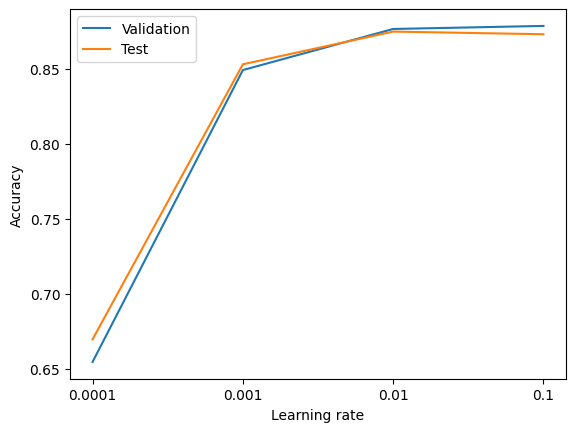

acc val: [0.6545777326908445, 0.8490996703018007, 0.87648998224702, 0.8785188942429623]
acc test: [0.6696247464503042, 0.8529411764705882, 0.8747464503042597, 0.8729716024340771]


In [12]:
lr_search = [1e-4, 1e-3, 0.01, 0.1]
epochs = 500
hid_dim = 64
n_layers = 2

acc_val_list = []
acc_test_list = []
data_pubmed = data_pubmed.cuda()
for lr in lr_search:
    set_seed(0)
    model = GCN(data_pubmed.num_features, hid_dim, data_pubmed.num_classes, num_layers=n_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model = model.cuda()
    print(f'Learning rate: {lr}')
    acc_dict = train_and_eval_once(model, data_pubmed, optimizer, nn.CrossEntropyLoss(), epochs=epochs, mute=True)
    acc_val_list.append(acc_dict['val'])
    acc_test_list.append(acc_dict['test'])

# plot
plt.plot([str(lr) for lr in lr_search], acc_val_list, label='Validation')
plt.plot([str(lr) for lr in lr_search], acc_test_list, label='Test')
# plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"acc val: {acc_val_list}")
print(f"acc test: {acc_test_list}")

Hidden dimension: 16


 38%|███▊      | 188/500 [00:00<00:01, 301.88it/s]


Early stopping at epoch 189
Hidden dimension: 32


 22%|██▏       | 111/500 [00:00<00:02, 139.72it/s]


Early stopping at epoch 112
Hidden dimension: 64


 31%|███       | 155/500 [00:01<00:02, 127.40it/s]


Early stopping at epoch 156
Hidden dimension: 128


 28%|██▊       | 139/500 [00:00<00:01, 247.38it/s]


Early stopping at epoch 140
Hidden dimension: 256


 35%|███▌      | 177/500 [00:01<00:02, 143.08it/s]


Early stopping at epoch 178
Hidden dimension: 512


 31%|███       | 156/500 [00:01<00:03, 91.63it/s]


Early stopping at epoch 157


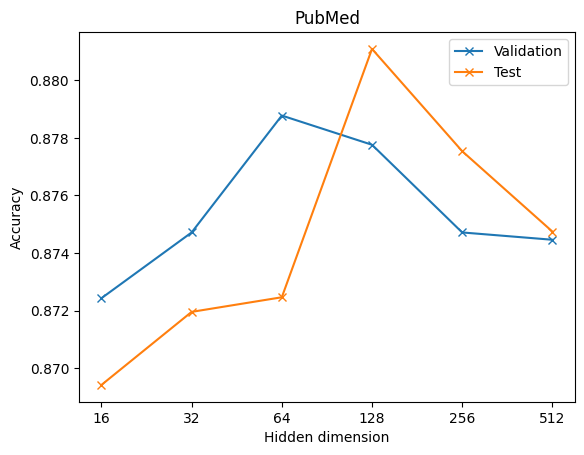

acc val: [0.8724321582551356, 0.8747146842505706, 0.878772508242455, 0.8777580522444839, 0.8747146842505706, 0.8744610702510779]
acc test: [0.869421906693712, 0.8719574036511156, 0.8724645030425964, 0.8810851926977687, 0.8775354969574036, 0.8747464503042597]


In [6]:
hid_dim_search = [16, 32, 64, 128, 256, 512]
epochs = 500
lr = 0.1
n_layers = 2

acc_val_list = []
acc_test_list = []
data_pubmed = data_pubmed.cuda()
for hid_dim in hid_dim_search:
    set_seed(0)
    model = GCN(data_pubmed.num_features, hid_dim, data_pubmed.num_classes, num_layers=n_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model = model.cuda()
    print(f'Hidden dimension: {hid_dim}')
    acc_dict = train_and_eval_once(model, data_pubmed, optimizer, nn.CrossEntropyLoss(), epochs=epochs, mute=True)
    acc_val_list.append(acc_dict['val'])
    acc_test_list.append(acc_dict['test'])

# plot
plt.plot([str(d) for d in hid_dim_search], acc_val_list, marker='x', label='Validation')
plt.plot([str(d) for d in hid_dim_search], acc_test_list, marker='x', label='Test')
plt.xlabel('Hidden dimension')
plt.ylabel('Accuracy')
plt.title('PubMed')
plt.legend()
plt.savefig('pubmed_gnn_hid_dim.pdf', bbox_inches='tight')
plt.show()

print(f"acc val: {acc_val_list}")
print(f"acc test: {acc_test_list}")

Number of layers: 2


 28%|██▊       | 139/500 [00:00<00:01, 206.27it/s]


Early stopping at epoch 140
Number of layers: 3


 36%|███▌      | 178/500 [00:01<00:02, 155.96it/s]


Early stopping at epoch 179
Number of layers: 4


 38%|███▊      | 189/500 [00:01<00:02, 122.40it/s]


Early stopping at epoch 190
Number of layers: 5


 54%|█████▍    | 269/500 [00:02<00:02, 97.49it/s]


Early stopping at epoch 270
Number of layers: 10


 17%|█▋        | 83/500 [00:01<00:08, 47.88it/s]


Early stopping at epoch 84


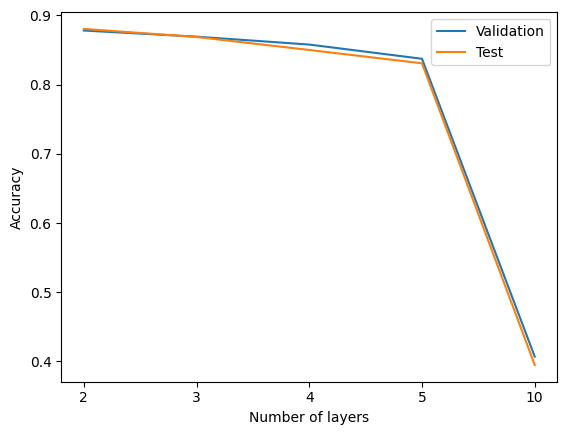

acc val: [0.8782652802434694, 0.8693887902612224, 0.8579761602840477, 0.8374334263251332, 0.40705046918589904]
acc test: [0.880578093306288, 0.8689148073022313, 0.8501521298174443, 0.8308823529411765, 0.39503042596348886]


In [17]:
hid_dim = 128
epochs = 500
lr = 0.1
n_layers_search = [2, 3, 4, 5, 10]

acc_val_list = []
acc_test_list = []
data_pubmed = data_pubmed.cuda()
for n_layers in n_layers_search:
    set_seed(0)
    model = GCN(data_pubmed.num_features, hid_dim, data_pubmed.num_classes, num_layers=n_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model = model.cuda()
    print(f'Number of layers: {n_layers}')
    acc_dict = train_and_eval_once(model, data_pubmed, optimizer, nn.CrossEntropyLoss(), epochs=epochs, mute=True)
    acc_val_list.append(acc_dict['val'])
    acc_test_list.append(acc_dict['test'])

# plot
plt.plot([str(d) for d in n_layers_search], acc_val_list, label='Validation')
plt.plot([str(d) for d in n_layers_search], acc_test_list, label='Test')
plt.xlabel('Number of layers')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"acc val: {acc_val_list}")
print(f"acc test: {acc_test_list}")